# Tox21 독성 예측 모델 

Tox21 dataset는 NIH(미국 국립보건원)에 의해 구축되었습니다. (https://paperswithcode.com/dataset/tox21-1)

dataset에는 해당 화합물의 구조화 함께 12가지 독성 여부가 포함되어 있습니다. 아래는 독성에 관한 설명으로 다양한 독성이 존재하며 1은 독성이 있는 것 0은 독성이 없는 화학물질 입니다.

- NR-AR : Androgen receptor using the MDA cell line
- NR-AR-LBD : Androgen receptor ligand binding domain
- NR-ER : Estrogen receptor α using the BG1 cell line
- NR-ER-LBD : Estrogen receptor α ligand binding domain
- NR-AhR : Aryl hydrocarbon receptor
- NR-Aromatase : Aromatase enzyme
- NR-PPAR-γ : Peroxisome - proliferator-activated receptor γ
- SR-ARE : Antioxidant response element
- SR-ATAD5 : Luciferase-tagged ATAD5 in human embryonic kidney cells
- SR-HSE : Heat shock response
- SR-MMP :  Mitochondrial membrane potential
- SR-p53 :  p53 response




화학물질 구조의 일반적인 표기는 SMILES를 사용합니다. SMILES는 원자와 결합을 character로 표현하는 방법입니다. 

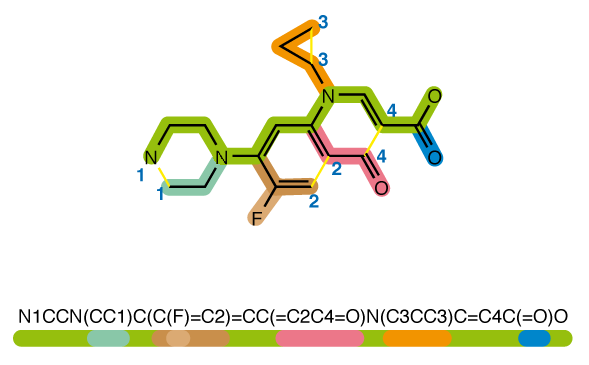

molecular fungerprint는 화학물질의 부분구조(sub structure)의 존재 여부를 1로 표현한 고정된 길이의 이진벡터로 표현. 화학분자의 구조를 디지털로 표현할 때 많이 사용되는 단순한 형태입니다.

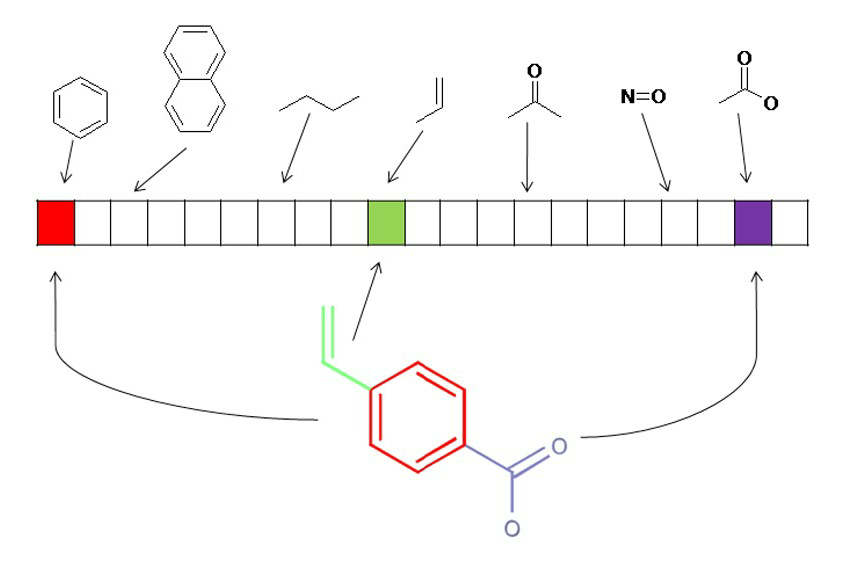

In [11]:
#RDkit은 화학물질을 변환하거나 분석, 처리하게 도와주는 라이브러리입니다.
!pip install rdkit-pypi

In [12]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem

#데이터프레임에는 분자의 구조가 적혀있는 SMILES와 id, 그리고 다양한 독성 여부가 기록되어 있습니다.
file_name = "tox21.csv"
df = pd.read_csv(file_name)
df.columns

Index(['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD',
       'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53',
       'mol_id', 'smiles'],
      dtype='object')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8014 entries, 0 to 8013
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NR-AR          7439 non-null   float64
 1   NR-AR-LBD      6902 non-null   float64
 2   NR-AhR         6691 non-null   float64
 3   NR-Aromatase   5940 non-null   float64
 4   NR-ER          6316 non-null   float64
 5   NR-ER-LBD      7112 non-null   float64
 6   NR-PPAR-gamma  6583 non-null   float64
 7   SR-ARE         5935 non-null   float64
 8   SR-ATAD5       7232 non-null   float64
 9   SR-HSE         6594 non-null   float64
 10  SR-MMP         5920 non-null   float64
 11  SR-p53         6909 non-null   float64
 12  mol_id         8014 non-null   object 
 13  smiles         8014 non-null   object 
dtypes: float64(12), object(2)
memory usage: 876.7+ KB


ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

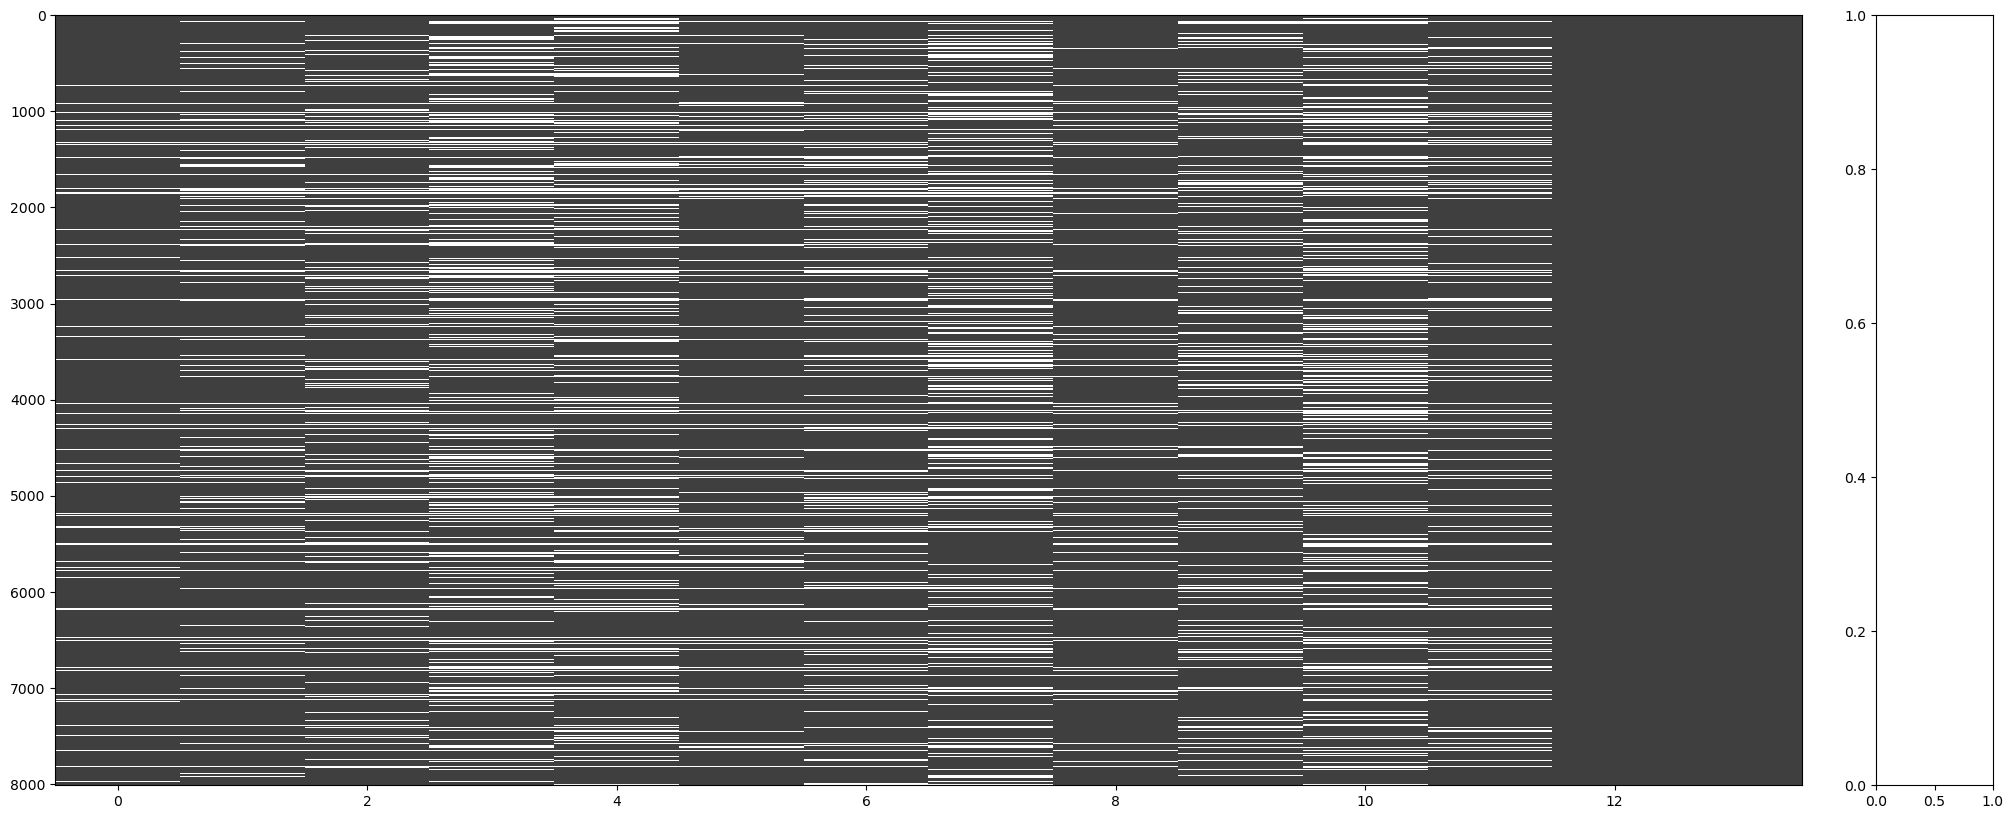

In [14]:
# 결측치 시각화
import missingno as msno
msno.matrix(df=df.iloc[:, :111])

In [ ]:
df['NR-AR'].value_counts()

0.0    7129
1.0     310
Name: NR-AR, dtype: int64

In [ ]:
df_smile = pd.read_csv('smile.csv')
# df_smile.to_csv('smile.csv')

In [ ]:
# 분자식(SMILES)을 1024 길이의 숫자 벡터(fingerprint)로 변환
def smiles_to_fingerprint(smiles, fp_length=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(fp_length)
    else:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=fp_length)
        return np.array(fp, dtype=np.float32)

df_smile = pd.DataFrame(list(df['smiles'].apply(smiles_to_fingerprint)))
#fp 열에 fingerprint로 변환된 구조를 넣었습니다.
df_smile

[09:26:19] WARNING: not removing hydrogen atom without neighbors


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
8011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8012,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [20]:
dict_smile = {}
for target in df.columns[:12]:
    new_df = pd.concat([df_smile, df[target]], axis = 1)
    new_df = new_df.dropna()
    dict_smile[target] = new_df

In [36]:
target = list(dict_smile.keys())[0]
x_data = dict_smile[target].drop(target, axis = 1)
y_data = dict_smile[target][target]

In [39]:
from sklearn.model_selection import train_test_split
# 자르기
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state = 102, test_size = 0.3)

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
parametersGrid = {"max_depth": [10, 20, 30],
                "max_features": np.arange(100, 1000, 100),
                "class_weight":[{0: 1, 1: 1}, {0: 1, 1: 5}]}

grid = GridSearchCV(model, param_grid = parametersGrid, cv=3, refit = True ,  scoring='recall')
grid.fit(x_train, y_train)
# score 순으로 어떤게 제일 좋았는지 알려준다.
pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score']]


,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 10, 'max_features': 100}",0.445946,4,0.486486,0.405405,0.445946
1,"{'max_depth': 10, 'max_features': 200}",0.436937,14,0.486486,0.378378,0.445946
2,"{'max_depth': 10, 'max_features': 300}",0.445946,4,0.486486,0.405405,0.445946
3,"{'max_depth': 10, 'max_features': 400}",0.441441,7,0.486486,0.405405,0.432432
4,"{'max_depth': 10, 'max_features': 500}",0.436937,14,0.486486,0.391892,0.432432
5,"{'max_depth': 10, 'max_features': 600}",0.436937,14,0.486486,0.391892,0.432432
6,"{'max_depth': 10, 'max_features': 700}",0.436937,14,0.486486,0.391892,0.432432
7,"{'max_depth': 10, 'max_features': 800}",0.432432,26,0.486486,0.378378,0.432432
8,"{'max_depth': 10, 'max_features': 900}",0.436937,14,0.486486,0.391892,0.432432
9,"{'max_depth': 20, 'max_features': 100}",0.436937,14,0.486486,0.391892,0.432432


In [53]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(100, max_depth = 10, max_features = 100, class_weight={0: 1, 1: 25})
forest.fit(x_train, y_train)


from sklearn.metrics import classification_report
print(classification_report(y_train, forest.predict(x_train)))
print(classification_report(y_test, forest.predict(x_test)))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      4985
         1.0       0.95      0.68      0.79       222

    accuracy                           0.98      5207
   macro avg       0.97      0.84      0.89      5207
weighted avg       0.98      0.98      0.98      5207

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2144
         1.0       0.75      0.44      0.56        88

    accuracy                           0.97      2232
   macro avg       0.86      0.72      0.77      2232
weighted avg       0.97      0.97      0.97      2232



In [52]:
y_train.value_counts()

0.0    4985
1.0     222
Name: NR-AR, dtype: int64

(Hint) 전처리 과정 중 만약 '그 곳'에서 어려움을 만났다면 이 문서 제일 아래에 있는 np.stack을 찾아 봅시다.

### 모델을 만들고 학습 후 평가해보세요

어떤 성능 지표를 써야 할까요?

47/47 [==============================] - 0s 4ms/step


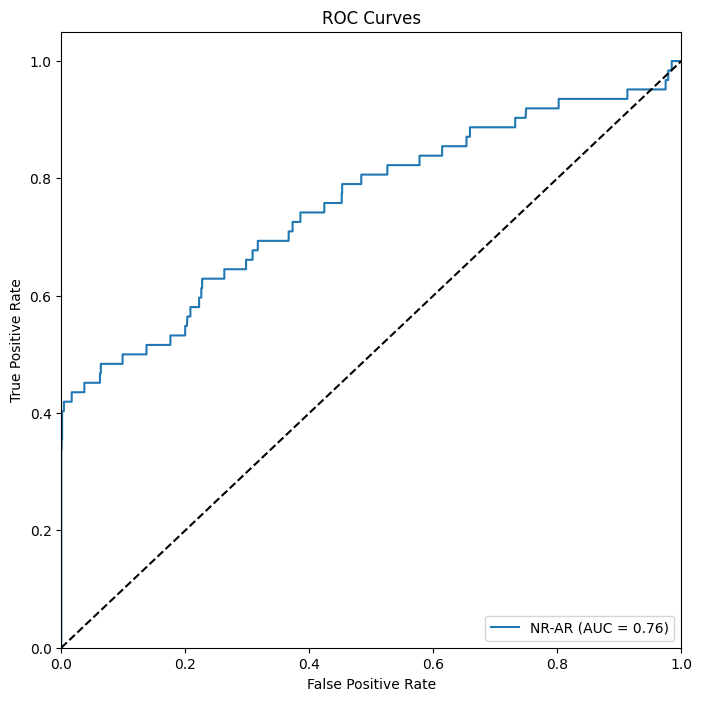

In [ ]:
from sklearn.metrics import roc_curve, auc

# 모델 학습 후 ROC 커브를 그려보세요
# 커브의 모양을 통해 어떤 정보를 알 수 있나요?

### 다양한 독성이 있습니다.

어떤 독성이 가장 예측하기 쉬운가요? 독성별 예측 성능을 비교해 봅시다.

표로 만들거나 그래프로 그려서 가장 예측이 쉬운 독성과 어려운 독성을 찾아봅시다.

In [4]:
#이 물질들은 독성이 있을까요? 없을까요? 추론해봅시다

sample_smiles = [
    'CC1=C(C=C(C=C1)C(=O)O)O',
    'C1=CNC(=C1)C(=O)N',
    'CC1=CC(=O)C(=C(C1)C)O',
    'C1=CC(=C(C=C1)O)O',
    'C1=CC(=C(C=C1[N+](=O)[O-])O)O',
    'C1=CC(=C(C=C1)O)N',
    'CC1=CC(=C(C=C1C)O)O',
    'C1=CC(=C(C=C1)O)C=O',
    'C1=CC(=C(C=C1O)O)C',
    'C1=CC(=C(C=C1)C)O'
]

# SMILES 문자열을 fingerprint으로 변환
sample_fp = np.stack([smiles_to_fingerprint(smiles) for smiles in sample_smiles])